In [1]:
import os
import glob
import json
import torch
import pickle
import numpy as np
from tqdm import tqdm
from PIL import Image

os.chdir("..")

# Utils

In [2]:
### utils

img_folder, anno_file = "./data/hico_20160224_det/images/train2015", "./data/hico_20160224_det/annotations/trainval_hico.json"
with open(anno_file, 'r') as f:
    annotations = json.load(f)

ids = []
for idx, img_anno in enumerate(annotations):
    for hoi in img_anno['hoi_annotation']:
        if hoi['subject_id'] >= len(img_anno['annotations']) or hoi['object_id'] >= len(img_anno['annotations']):
            break
    else:
        ids.append(idx)

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

from torchvision.ops.boxes import box_area
def box_iou(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter

    iou = inter / union
    return iou, union

def generalized_box_iou(boxes1, boxes2):
    """
    Generalized IoU from https://giou.stanford.edu/

    The boxes should be in [x0, y0, x1, y1] format

    Returns a [N, M] pairwise matrix, where N = len(boxes1)
    and M = len(boxes2)
    """
    # degenerate boxes gives inf / nan results
    # so do an early check
    assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
    assert (boxes2[:, 2:] >= boxes2[:, :2]).all()
    iou, union = box_iou(boxes1, boxes2)

    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    area = wh[:, :, 0] * wh[:, :, 1]

    return iou - (area - union) / area

# Visualization

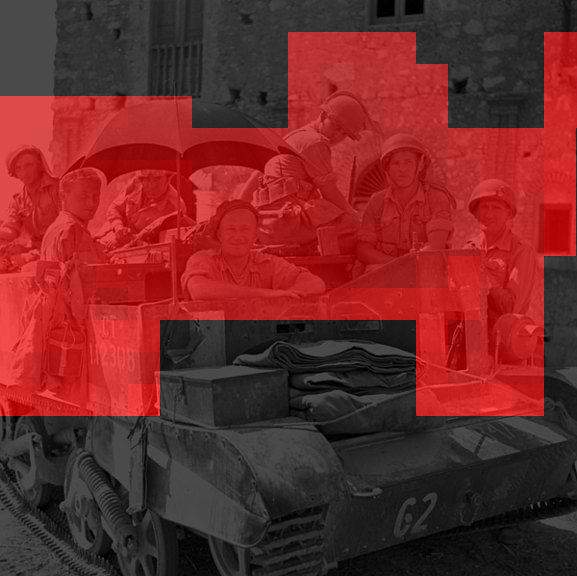

In [6]:
import math
from PIL import ImageDraw
import torch.nn.functional as F

# modify path&index
path = './exp/vis/att_0_0.pth'
index = 1
data = torch.load(path, map_location="cpu")

idx, size = data["id"][index], data["size"][index]
binary_decoder_weight = data["binary_decoder_weight"].squeeze()[:, index]
pred_sub_boxes, pred_obj_boxes, pred_binary_logits, pred_part_binary_logits = data["pred_sub_boxes"][index], data["pred_obj_boxes"][index], \
data["pred_binary_logits"][index], data["pred_part_binary_logits"][:, index]
pred_binary_logits = F.softmax(torch.from_numpy(pred_binary_logits), -1)[..., 1].numpy()

img_anno = annotations[ids[idx]]
img = Image.open(os.path.join(img_folder, img_anno['file_name'])).convert('RGB')
w, h = img.size

for i in range(64):
    pred_sub_boxes[i] = box_cxcywh_to_xyxy(torch.from_numpy(pred_sub_boxes[i])).numpy().tolist()
    pred_sub_boxes[i] = [w * pred_sub_boxes[i][0], h * pred_sub_boxes[i][1], w * pred_sub_boxes[i][2], h * pred_sub_boxes[i][3]]
for i in range(64):
    pred_obj_boxes[i] = box_cxcywh_to_xyxy(torch.from_numpy(pred_obj_boxes[i])).numpy().tolist()
    pred_obj_boxes[i] = [w * pred_obj_boxes[i][0], h * pred_obj_boxes[i][1], w * pred_obj_boxes[i][2], h * pred_obj_boxes[i][3]]

h_load, w_load = size
h_batch, w_batch = data["batch_shape"][1:]
wh_dict = {"w_batch": w_batch, "h_batch":h_batch, "w_load": int(w_load), "h_load": int(h_load)}

index2xy = []
for i in range(0, math.ceil(h_batch / 32)):
    for j in range(0, math.ceil(w_batch / 32)):
        index2xy.append([i, j])

xy2index = {}
for k, (i, j) in enumerate(index2xy):
    xy2index[(i, j)] = k

query_id = np.argmax(pred_binary_logits)
# query_id = 62
draw = ImageDraw.Draw(img)
layer = 1

img_batch = Image.new("RGB", (wh_dict["w_batch"], wh_dict["h_batch"]), (0, 0, 0))
img_batch.paste(img.resize((wh_dict["w_load"], wh_dict["h_load"])), (0,0))

img_att = Image.new("RGB", img_batch.size, (0, 0, 0))
draw = ImageDraw.Draw(img_att)

weight = binary_decoder_weight[layer, query_id]
weight = (weight - np.min(weight)) / (np.max(weight) - np.min(weight))

for i in range(len(weight)):
    index_i, index_j = index2xy[i]
    w_min, w_max = index_j*32, index_j*32+32
    h_min, h_max = index_i*32, index_i*32+32
    draw.rectangle([(w_min, h_min), (w_max, h_max)], fill=(int(255 * weight[i]), 0, 0))
    draw.rectangle(pred_sub_boxes[query_id], fill=None, outline=(0, 139, 69), width=4)
    draw.rectangle(pred_obj_boxes[query_id], fill=None, outline=(0, 0, 128), width=4)

img_att = Image.blend(img_batch, img_att, alpha = 0.7)
img_att = img_att.crop([0, 0, wh_dict["w_load"], wh_dict["h_load"]])
img_att
# img_att.save("./exp/vis_pic/%s_%s_%s.jpg"%(idx, layer, query_id))